# DSCI 100 Final Project - Group 05 - [Title]
**Group Members:** Caitlyn Woods, Amy Zhang, Ziyang Shen


## Introduction

In this report, we will analyze data collected by a UBC Computer Science research group using strategies taught in the DSCI 100 course to answer a research question. However, before discussing the specifics of the research question and datasets, it is crucial to have a basic understanding of the tools and strategies used throughout this report. Simply put, we will be using a variety of strategies, including summarizing, visualizing, and modelling, to gain a better understanding of and derive useful information from the data we have been provided. These strategies will be explained in the "methods and results" section. All code included in this report will be written in R, and will use functions from several libraries, notably the Tidyverse and ggplot2 libraries [If there are any others that need to be mentioned, let me know or add them here]. When we refer to a "dataset", we are referencing a specific table of data, while an "observation" refers to a row of this table, and a "variable" is a column of the table. 

In this report, we will explore the broad question: "We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players." (DSCI 100, "Project Planning Stage Instructions"). To do so, we will answer the specific research question, "Can the total number of hours a player has accumulated (from players.csv) and the duration of their previous sessions (from sessions.csv) predict whether they will start a new session in the next 24 hours?". By answering the research question, we will learn whether our method for predicting when players will be online (within 24 hours) is successful, thus providing a starting point for predicting demand for more precise time frames. 

To answer the research question, we will use two datasets, "players.csv" and "sessions.csv". The first dataset, which we will call "players" in this report, provides information about individual players and includes the information name, gender, age, hours played, experience level, email (hashed), and whether they are subscribed to the newsletter. The second dataset, which we will call "sessions", is a record of all sessions played by all players, including the start time, end time, and email (hashed). The start and end times are included both in the DD/MM/YYYY HH:MM format and the "original time", which is a standardized time frame often used in computer science. To answer our research question, we will combine the two data sets by player email (hashed) to look at both the sessions played and the total hours played. To do so, we will first have to group the sessions dataset by email (hashed) to have all played sessions for each player.  

## Methods

To address our research question "whether a player’s total accumulated hours (from players) and the duration of their previous sessions (from sessions) can predict whether they will start a new session within the next 24 hours", we performed a complete data-analysis workflow in R. This section describes the full sequence of methods used, from loading the data to building and evaluating the predictive model. All analysis was completed in R, using functions from the tidyverse, lubridate, and class libraries (if additional packages are used in the final code, they should be added here).

**1. Loading the Data**

We begin by importing the two datasets, players.csv and sessions.csv, into R. Each dataset is loaded as a tibble to support tidyverse workflows.
A reproducible seed is set at the beginning of the analysis to ensure consistent model results.


In [58]:
# Load package + Read data
library(tidyverse)

players  <- read_csv("https://raw.githubusercontent.com/zzzlnn/dsci-100-group-project/refs/heads/main/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/zzzlnn/dsci-100-group-project/refs/heads/main/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


**2. Data Wrangling and Cleaning**


2.1 Preparing the sessions dataset

The sessions dataset contains multiple rows per player, one per game session. To construct features meaningful for prediction, we:

Convert the start and end times into date-time objects using lubridate.

Compute the duration of each session in hours.

Group sessions by hashed email to calculate:

the average session duration per player,

the number of historical sessions per player,

the timestamp of the player’s most recent session.

Create a new binary outcome variable indicating whether a given player starts a new session within 24 hours after their latest recorded session.


2.2 Preparing the players dataset

The players dataset contains one row per player. We:

Select relevant player-level variables (age, gender, hours played, experience level).

Ensure each column has an appropriate data type (e.g., factors for categorical variables, numeric values for continuous variables).


2.3 Merging datasets

We join the cleaned players and sessions-summary datasets by the hashed email field. This produces a tidy, one-row-per-player dataset containing both player-level and aggregate session-level features.



In [59]:
#  Calculate the duration of each game (in hours)

ms_per_hour <- 1000 * 60 * 60 
ms_per_hour

sessions_time <- sessions |>
  mutate(duration_hours =
         (original_end_time - original_start_time) / ms_per_hour)
head(sessions_time)

[1] 3600000

hashedEmail,start_time,end_time,original_start_time,original_end_time,duration_hours
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,0
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,0
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,0
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12,0
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12,0
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12,0


In [60]:
# Summarise the data of each player
sessions_summary <- sessions_time |>
  
group_by(hashedEmail) |>
  
summarise(n_sessions = n(),
   
    avg_session_duration = mean(duration_hours),  
    # The most recent start time
 
    last_start = max(original_start_time), 
    # How many games (including the last one) have there been in the past 24 hours?
   
    n_in_last_24h = sum(original_start_time >= last_start - 24 * ms_per_hour),
   # If there are more than one game in the last 24 hours, it will be recorded as 1; otherwise, it will be 0.
    
    start_within_24h = as.integer(n_in_last_24h > 1))

sessions_summary

hashedEmail,n_sessions,avg_session_duration,last_start,n_in_last_24h,start_within_24h
<chr>,<int>,<dbl>,<dbl>,<int>,<int>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,2,1.3888889,1.71642e+12,2,1
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,1,0.0000000,1.71955e+12,1,0
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,1,0.0000000,1.72678e+12,1,0
0d4d71be33e2bc7266ee4983002bd930f69d304288a8663529c875f40f1750f3,13,0.8547009,1.72523e+12,1,0
0d70dd9cac34d646c810b1846fe6a85b9e288a76f5dcab9c1ff1a0e7ca200b3a,2,1.3888889,1.71382e+12,1,0
11006065e9412650e99eea4a4aaaf0399bc338006f85e80cc82d18b49f0e2aa4,1,0.0000000,1.72215e+12,1,0
119f01b9877fc5ea0073d05602a353b91c4b48e4cf02f42bb8d661b46a34b760,1,0.0000000,1.71247e+12,1,0
18936844e06b6c7871dce06384e2d142dd86756941641ef39cf40a9967ea14e3,41,0.4065041,1.72050e+12,2,1
1a2b92f18f36b0b59b41d648d10a9b8b20a2adff550ddbcb8cec2f47d4d881d0,1,0.0000000,1.72601e+12,1,0


In [61]:
# Combine "players" and "sessions_summary" together
data_full <- players |>
  inner_join(sessions_summary, by = "hashedEmail")
# Inner join is to align and merge the two tables by a certain column (hashedEmail)

**3. Exploratory Data Analysis (EDA)**

To better understand the data before modelling, we produce both numerical summaries and visualizations:


3.1 Numerical Summaries

We compute summary statistics (mean, median, range, standard deviation) for variables relevant to prediction, including:

total hours played,

number of sessions,

average session duration,

age,

experience level.

These statistics allow us to inspect variable distributions and identify outliers or unusual patterns.


3.2 Exploratory Visualizations

To visualize relationships between predictors and the outcome, we create at least one exploratory figure (e.g., Figure 1), such as:

a histogram or density plot of total hours played,

a boxplot comparing average session duration for players who did vs. did not start a session within 24 hours.

Each figure is labeled with a figure number and legend.


In [62]:
# Summary
data_full |>
  summarise(
    n_players = n(),
    prop_start_24h = mean(start_within_24h),
    median_hours = median(played_hours),
    median_sessions = median(n_sessions),
    median_duration = median(avg_session_duration))

n_players,prop_start_24h,median_hours,median_sessions,median_duration
<int>,<dbl>,<dbl>,<int>,<dbl>
125,0.168,0.3,1,NA


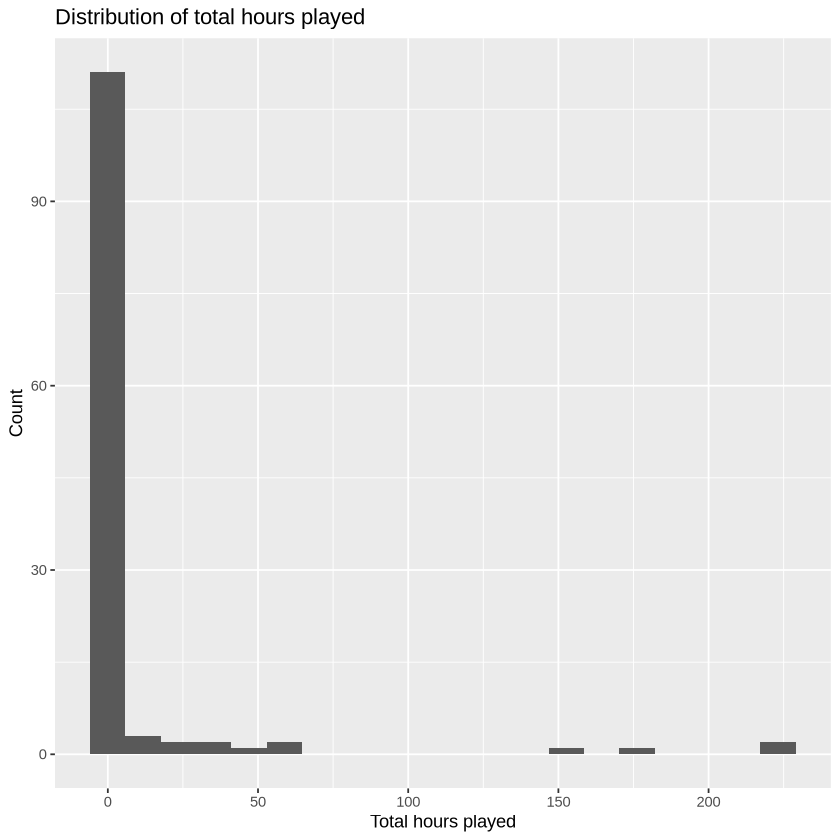

In [63]:
# Figure 1

ggplot(data_full, aes(x = played_hours)) +
  geom_histogram(bins = 20) +
  labs( title = "Distribution of total hours played",
    x = "Total hours played",
    y = "Count") 

start_within_24h,mean_duration
<fct>,<dbl>
No,0.4406143
Yes,0.7819457


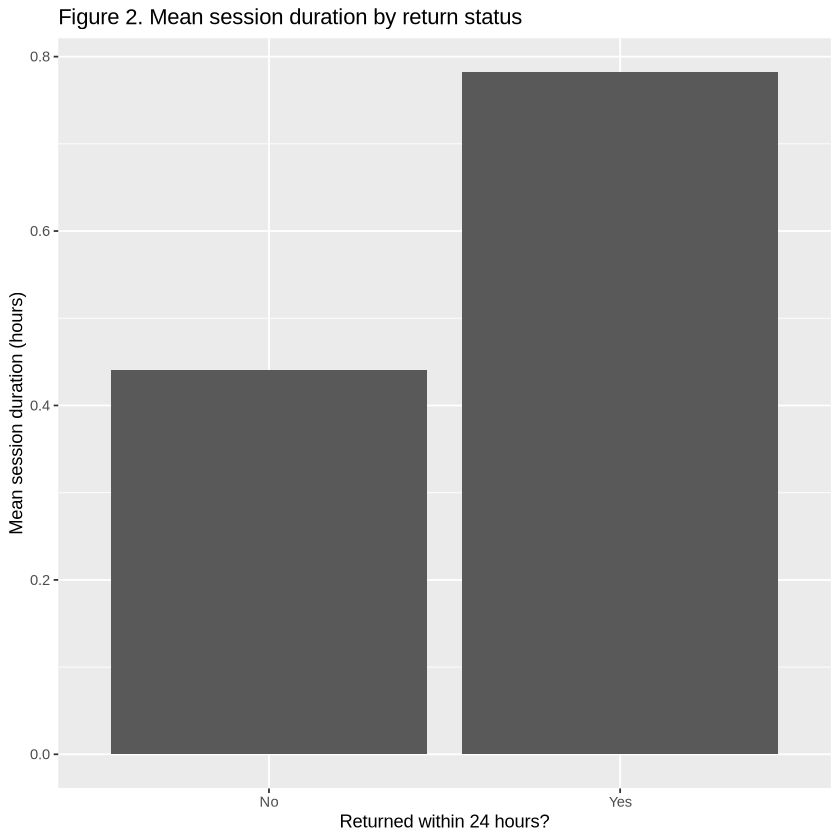

In [64]:
#Figure 2

duration_summary <- data_full |>
  mutate(start_within_24h = factor(start_within_24h,
                                   levels = c(0, 1),
                                   labels = c("No", "Yes"))) |>
  group_by(start_within_24h) |>
 
  summarise(mean_duration = mean(avg_session_duration, na.rm = TRUE))

duration_summary


ggplot(duration_summary,
       aes(x = start_within_24h, y = mean_duration)) +
  geom_col() +
  labs(
    title = "Figure 2. Mean session duration by return status",
    x = "Returned within 24 hours?",
    y = "Mean session duration (hours)") 


**4. Modeling Approach: K-Nearest Neighbors (KNN) Classification**

4.1 Rationale for KNN

We use a K-Nearest Neighbors (KNN) classifier to predict whether a player will start a session in the next 24 hours. This method is appropriate because:

The outcome is binary.

KNN is taught in the course and suitable for classification tasks.

It makes few distributional assumptions.

With proper preprocessing, it can handle both numeric and categorical predictors.

4.2 Assumptions

KNN operates under several key assumptions:

Similarity assumption: players close in feature space should have similar outcomes.

Meaningful distance metric: predictors must be scaled to ensure fair comparisons.

Feature standardization: numeric predictors are centered and scaled.

Adequate local data: sufficient nearby neighbors must exist for reliable predictions.



**5. Data Processing for Modeling**

5.1 Train–Test Split

Before any preprocessing, we split the data into:

80% training set – used for preprocessing, tuning, and cross-validation,

20% test set – used only for final evaluation.

This prevents data leakage.


5.2 Feature Preprocessing

To prepare predictors for KNN:

Numeric features (hours played, average session duration, number of sessions, age) are standardized.

Categorical features are converted into numerical indicators as taught in the course.

Preprocessing steps are learned from the training set and applied identically to the test set.



In [65]:
# KNN classification
library(tidymodels)
set.seed(123)

data_full <- data_full |>
  mutate(start_within_24h = factor(start_within_24h,
      levels = c(0, 1),
      labels = c("No", "Yes")))

In [66]:
player_split <- initial_split(data_full, prop = 0.8,
                              strata = start_within_24h)

player_train <- training(player_split)
player_test  <- testing(player_split)

In [67]:
player_train_clean <- player_train |>
  drop_na(played_hours, n_sessions, avg_session_duration, Age)

player_test_clean <- player_test |>
  drop_na(played_hours, n_sessions, avg_session_duration, Age)

In [68]:
player_recipe <- recipe(
  start_within_24h ~ played_hours + n_sessions + avg_session_duration + Age,
  data = player_train_clean) |>
  step_normalize(all_numeric_predictors())

In [69]:
knn_spec <- nearest_neighbor(neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [70]:
knn_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec)

**6. Model Training and Cross-Validation**

We evaluate several values of k (e.g., 3, 5, 7, 9, …) using 10-fold cross-validation on the training data.
For each value of k, we record the classification accuracy.

The optimal value of k is chosen as the one with the highest cross-validated accuracy, and that value is used to fit the final KNN model.

We visualize the cross-validation results (e.g., Figure 2), showing accuracy as a function of k.


In [83]:
player_folds <- vfold_cv(player_train_clean,
                         v = 10,
                         strata = start_within_24h)

In [84]:
k_grid <- tibble(neighbors = c(3, 5, 7, 9, 11, 13, 15))

In [85]:
knn_tuned <- knn_workflow |>
  tune_grid(resamples = player_folds,
    grid = k_grid,
    metrics = metric_set(accuracy))


In [86]:
collect_metrics(knn_tuned)

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
3,accuracy,binary,0.8444444,10,0.02222222,Preprocessor1_Model1
5,accuracy,binary,0.8144444,10,0.03602506,Preprocessor1_Model2
7,accuracy,binary,0.8144444,10,0.03602506,Preprocessor1_Model3
9,accuracy,binary,0.8155556,10,0.03557098,Preprocessor1_Model4
11,accuracy,binary,0.7955556,10,0.03591638,Preprocessor1_Model5
13,accuracy,binary,0.7844444,10,0.03439463,Preprocessor1_Model6
15,accuracy,binary,0.7733333,10,0.02782465,Preprocessor1_Model7


In [87]:
best_k <- select_best(knn_tuned, "accuracy")
best_k

final_knn <- knn_workflow |>
  finalize_workflow(best_k) |>
  fit(data = player_train_clean)

neighbors,.config
<dbl>,<chr>
3,Preprocessor1_Model1


In [88]:
pred_test <- predict(final_knn, new_data = player_test_clean) |>
  bind_cols(player_test_clean |> select(start_within_24h))


metrics(pred_test,
        truth = start_within_24h,
        estimate = .pred_class)


conf_mat(pred_test,
         truth = start_within_24h,
         estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8000000
kap,binary,0.4292237


          Truth
Prediction No Yes
       No  17   1
       Yes  4   3

* The final KNN model reached an accuracy of 80%. It predicts non-returning players quite well, but it has more difficulty identifying players who return within 24 hours.

**7. Final Model Evaluation**

The selected model is then applied to the test set.
We compute standard classification metrics taught in the course, including:

overall test accuracy,

confusion matrix (optional),

qualitative interpretation of model performance.

A final visualization (e.g., Figure 3) may be included to illustrate predicted vs. actual outcomes or to display decision boundaries if appropriate.

## Visualization

Our focus of the question is the total hours played (`played_hours`). However, Figure 2's data table shows a clear distinction in the `mean_duration` of play for each player. Since our question is more about the immediate behaviour of users (next 24 hours), it is worth looking at if the average hours of play each session (`avg_session_duration`) will influence more than total accumulated hours.

Warning message in scale_y_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message in scale_x_continuous(trans = "log10"):
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


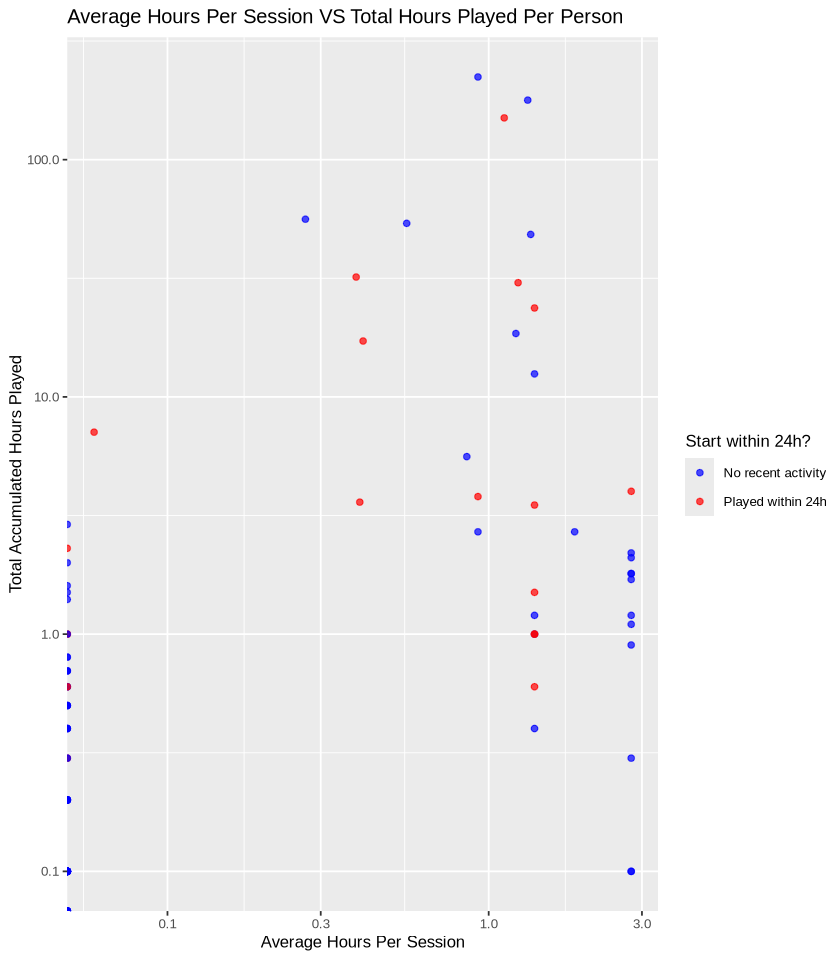

In [23]:
#Figure 3
options(repr.plot.width = 7, repr.plot.height = 8) 
total_vs_average <- data_full |>
    mutate(start_within_24h = factor(start_within_24h)) |>
    ggplot(aes(x = avg_session_duration, y = played_hours, color = start_within_24h)) +
    geom_point(alpha = 0.7) +
    labs(x = "Average Hours Per Session",
         y = "Total Accumulated Hours Played",
         title = "Average Hours Per Session VS Total Hours Played Per Person",
         color = "Started Another Game? 1 is Yes, 0 is no") +
        scale_color_manual(
            values = c("0" = "blue", "1" = "red"),
            labels = c("0" = "No recent activity", "1" = "Played within 24h"),
            name = "Start within 24h?") +
        #xlim(0, 5) +
        #ylim(0, 70) +
        scale_y_continuous(trans = 'log10') + #scale the y to logarithmic 
        scale_x_continuous(trans = 'log10') + #scale the x to logarithmic 
        theme(text = element_text(size = 10))
total_vs_average

It might be possible that Average Hours Played Per Session is more influential as seen the above plot, where It might be possible that Average Hours Played Per Session is more influential as seen in the above plot, where the red and blue dots are heavily mixed along the vertical axis played_hours, but are separated along the horizontal axis avg_session_duration.

## Discussion and Conclusion
Performance and Predictor Influence
Our main goal was to see whether a player's activity history could help predict if they would return to the game within 24 hours. One challenge was that the data was heavily imbalanced--most players simply did not return in that time window. After building and tuning our K-Nearest Neighbors (KNN) model, we reached an accuracy of about 80% on the test data. While this sounds strong, the low proportion of returning players (prop_start_24h = 16.8%) means the model might achieve high accuracy partly by predicting the majority class, so accuracy alone doesn’t tell the full story.

To better understand the model’s limitations, we looked at the visual distribution of predictions. A noticeable strip of blue points (non-returning players) in Figure 3 appeared on the far right of the plot—these were players who had long average sessions but still didn’t return within 24 hours. They form the model’s key false negatives. Their presence shows why the model cannot reach perfect accuracy as session duration, while helpful, isn’t enough to explain every player’s behavior. This pattern suggests that other factors like player satisfaction, life responsibilities, or frustration might play a role in whether a player comes back quickly.

With that in mind, our most important finding becomes clear. Average session duration turned out to be much more informative than total hours played. Players who returned within 24 hours averaged 0.78 hours per session, while players who didn’t return averaged only 0.44 hours. This indicates that recent, focused engagement matters more for short-term return than a player’s lifetime total playtime. At first, we assumed that high-hour, long-term players would be the most likely to come back, but our results showed that a player’s recent momentum is a better signal.

### Real-World Impact
These findings have practical value for the game company. If longer individual sessions are indeed linked to higher return rates, developers can use this insight to design content that naturally encourages players to stay a bit longer but not too long — such as well-paced quests, engaging story segments, or timed events. Even a small increase in average session duration could meaningfully improve next-day return rates, making this a straightforward way to support player retention.

### Future Questions
Although this project gave us useful insights, it also raises questions for future work.

* Handling class imbalance:

   Because most players did not return within 24 hours, our accuracy metric can be misleading. Future work should explore strategies like sampling more on players returned within 24 hours to reach a balance, or using algorithms designed for imbalanced data. These approaches would help ensure the model isn’t simply defaulting to the majority class.

* Choosing the right time window:

   We focused on a 24-hour prediction window, but it’s worth exploring whether a different timeframe such as 12 hours or 7 days—might be more meaningful. The day of the week could also influence return behavior (for example, weekend players may act differently), so including features that capture timing patterns would help reduce temporal bias.

* Comparing models:

  Finally, we only tested with KNN. As we learn more classification methods, we should compare KNN with other models to see whether a different technique offers better accuracy, interpretability, or stability.

